<h2><center> Image Classification of Birds using the iNaturalist Dataset</center></h2>
<h3><center>Springboard | Capstone 2: In-Depth Analysis/Modeling </center></h3>
<h4><center>By: Lauren Broussard</center></h4>

In [1]:
# !pip install tensorflow
# !pip install keras

First, we'll import the necessary packages. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # to split into training and testing data 

import keras
from keras.preprocessing.image import ImageDataGenerator # for image processing
from keras.models import Sequential,load_model #used to build initial model 
from keras.layers import Activation, Dense, Dropout, Flatten #Dense used to add layers to model
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import SGD #this is for optimization on learning rate

----

We will run our project from end to end with this number of images to account for run time. 

In [3]:
IMG_COUNT = 2000

----

### PRE-PROCESSING

Since the computing power on my personal laptop is limited, I will run the project end to end with a smaller amount of images, and will gradually increase the number of images over time. 

To this end, we'll import our original file, and grab a random subset of images to train, validate, and test with. Further, to balance out our dataset, we'll take an equal number of images showing birds and an equal number that are not birds. 

In [4]:
# import clean annotation file
df = pd.read_csv('../data/interim/wildlife_interim.csv')

In [5]:
# get random sample of images -- half birds, and half not birds
df_bird = df[df.is_bird == 1].sample(n=int(IMG_COUNT/2), random_state=42) # half birds
df_no_bird = df[df.is_bird == 0].sample(n=int(IMG_COUNT/2),random_state=42) # half not birds
df = pd.concat([df_bird, df_no_bird], axis=0) #merge two groups together
df.is_bird = df.is_bird.astype(str) # change bird indicator to string to fit model specs

In [6]:
# split dataframe into training, validation, and test dataframes
df_train, df_val = train_test_split(df,test_size=0.2, random_state=42)
df_train, df_test = train_test_split(df_train,test_size=0.3, random_state=42)

print("Number of Training Images: ",len(df_train))
print("Number of Validation Images: ", len(df_val))
print("Number of Test Images: ", len(df_test))

Number of Training Images:  1120
Number of Validation Images:  400
Number of Test Images:  480


### SET UP 

We'll set some constant values for our model below. 

In [7]:
# Model configuration
img_dir = "../data/raw/" # where images are stored
img_width, img_height = 128,128 # resize images to account for smallest img size
batch_size = 64
no_epochs = 7 # chosen after early stopping 
no_classes = 2 # choices of bird or not bird
#patience = 2 # for Early Stopping callback 

#how many epochs to go without model improving 
#early_stopping_monitor = EarlyStopping(patience=patience) 

#### Augment Images - Training

We'll do random augmentation of our each of our image subgroups, which will help rescale and shift them, and can help prevent overfitting for our training data.

In [8]:
%%time
train_datagen = ImageDataGenerator(
                    rescale=1./255, 
                    horizontal_flip = True,    
                    zoom_range = 0.3,
                    width_shift_range = 0.3,
                    height_shift_range=0.3)


train_generator = train_datagen.flow_from_dataframe(
                    dataframe= df_train,
                    directory=img_dir,
                    x_col="file_name",
                    y_col="is_bird",
                    batch_size=batch_size,
                    shuffle=True,
                    class_mode="binary",    
                    target_size=(img_height,img_width))

Found 1120 validated image filenames belonging to 2 classes.
CPU times: user 12.8 ms, sys: 4.47 ms, total: 17.2 ms
Wall time: 16.5 ms


#### Augment Images - Validation and Testing

In [9]:
%%time
val_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=val_datagen.flow_from_dataframe(
                    dataframe=df_val,
                    directory=img_dir,
                    x_col="file_name",
                    y_col="is_bird",
                    batch_size=batch_size,
                    class_mode="binary",    
                    target_size=(img_height,img_width))

Found 400 validated image filenames belonging to 2 classes.
CPU times: user 7.74 ms, sys: 2.44 ms, total: 10.2 ms
Wall time: 9.22 ms


#### Define Functions for Plotting:

In [10]:
def plot_accuracy_and_loss(model):
    '''Create graphs of training and validation accuracy and loss.'''
    
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(no_epochs) # can break here; epochs stop at 7

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### MODEL 1.

For our first model, we'll create a simple neural network to see how it does. We'll add five hidden layers, and a flatten layer. Our first layer will include 32 nodes, and we'll use ReLU activation for each of our hidden layers.

#### Set Architecture

In [11]:
model1 = Sequential()

model1.add(Dense(32,activation = 'relu', input_shape = (img_width,img_height,3)))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(32, activation = 'relu'))

model1.add(Flatten())
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(100, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

#### Compile

In [12]:
%%time
# compile, and add metrics==['accuracy'] to keep track of diagnostics for each epoch
model1.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

CPU times: user 6.62 ms, sys: 1.09 ms, total: 7.71 ms
Wall time: 6.68 ms


#### Fit

In [13]:
%%time
model1_history = model1.fit(
    train_generator,
    steps_per_epoch= len(df_train) // batch_size,
    epochs=no_epochs,
    validation_data=valid_generator,
    validation_steps= len(df_val) // batch_size,
    verbose=2)

Epoch 1/7
17/17 - 22s - loss: 2.5843 - accuracy: 0.5285 - val_loss: 0.7057 - val_accuracy: 0.5026
Epoch 2/7
17/17 - 21s - loss: 0.6776 - accuracy: 0.5549 - val_loss: 0.6185 - val_accuracy: 0.6589
Epoch 3/7
17/17 - 20s - loss: 0.6252 - accuracy: 0.6526 - val_loss: 0.7094 - val_accuracy: 0.5729
Epoch 4/7
17/17 - 19s - loss: 0.6134 - accuracy: 0.6667 - val_loss: 0.5601 - val_accuracy: 0.7240
Epoch 5/7
17/17 - 19s - loss: 0.5885 - accuracy: 0.6809 - val_loss: 0.6251 - val_accuracy: 0.6797
Epoch 6/7
17/17 - 21s - loss: 0.5887 - accuracy: 0.6847 - val_loss: 0.5215 - val_accuracy: 0.7422
Epoch 7/7
17/17 - 22s - loss: 0.5559 - accuracy: 0.7114 - val_loss: 0.5352 - val_accuracy: 0.7318
CPU times: user 5min 58s, sys: 2min 25s, total: 8min 23s
Wall time: 2min 34s


#### View Model Summaries

In [14]:
# view model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128, 128, 32)      128       
_________________________________________________________________
dense_1 (Dense)              (None, 128, 128, 32)      1056      
_________________________________________________________________
dense_2 (Dense)              (None, 128, 128, 32)      1056      
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                16777248  
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1

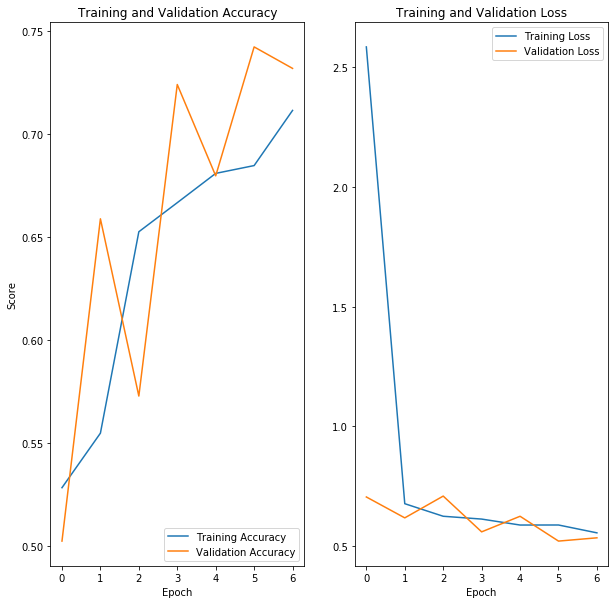

In [15]:
plot_accuracy_and_loss(model1_history)

#### Save Model

In [16]:
# save model
file_name = 'model1.h5'
model1.save('../models/{}'.format(file_name))

----

### MODEL 2.

Let's run another model using Convolutional Neural Networks (CNN).

#### Add Layers

In [17]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), input_shape=(img_width,img_height,3))) #convolution layer
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2))) #

model2.add(Conv2D(32, (3, 3))) #receives input from previous conv layer
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(100))
model2.add(Activation('relu'))
model2.add(Dropout(0.6)) # what proportion to drop out
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

#### Compile

In [18]:
%%time
# compile, and add metrics==['accuracy'] to keep track of diagnostics for each epoch
model2.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

CPU times: user 6.09 ms, sys: 993 µs, total: 7.08 ms
Wall time: 6.19 ms


#### Fit

In [30]:
#how many epochs to go without model improving
early_stopping_monitor = EarlyStopping(patience=2) 

In [32]:
%%time
model2_history = model2.fit(
    train_generator,
    steps_per_epoch= len(df_train) // batch_size,
    epochs=15,
    validation_data=valid_generator,
    validation_steps= len(df_val) // batch_size,
    callbacks = [early_stopping_monitor],
    verbose=2)

Epoch 1/15
17/17 - 18s - loss: 0.5747 - accuracy: 0.7102 - val_loss: 0.5207 - val_accuracy: 0.7448
Epoch 2/15
17/17 - 18s - loss: 0.5531 - accuracy: 0.7254 - val_loss: 0.5422 - val_accuracy: 0.7318
Epoch 3/15
17/17 - 19s - loss: 0.5491 - accuracy: 0.7263 - val_loss: 0.5388 - val_accuracy: 0.7396
CPU times: user 2min 9s, sys: 37.6 s, total: 2min 47s
Wall time: 59.1 s


#### Training & Validation Summary

In [21]:
# show summary 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)       

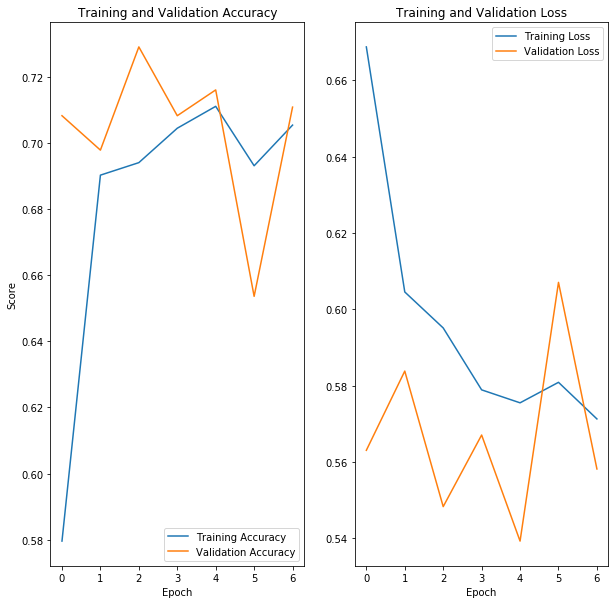

In [22]:
# plot 
plot_accuracy_and_loss(model2_history)

In [23]:
# save model
file_name = 'model2.h5'
model2.save('../models/{}'.format(file_name))

#### Predict

In [24]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_test,
                    directory=img_dir,
                    x_col="file_name",
                    y_col="is_bird",
                    batch_size=batch_size,
                    class_mode="binary",    
                    target_size=(img_height,img_width))

Found 480 validated image filenames belonging to 2 classes.


### RESULTS & VISUALIZATIONS

In [26]:
%%time
test_generator.reset()

# make predictions on model1
y_pred =model1.predict(test_generator,verbose=2)

y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Not Bird', 'Bird']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

8/8 - 5s
Confusion Matrix
[[236   0]
 [244   0]]
Classification Report
              precision    recall  f1-score   support

    Not Bird       0.49      1.00      0.66       236
        Bird       0.00      0.00      0.00       244

    accuracy                           0.49       480
   macro avg       0.25      0.50      0.33       480
weighted avg       0.24      0.49      0.32       480

CPU times: user 10.4 s, sys: 2.89 s, total: 13.3 s
Wall time: 6.13 s


In [25]:
%%time
test_generator.reset()

# make predictions on model2
y_pred =model2.predict(test_generator,verbose=2)

y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Not Bird', 'Bird']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

8/8 - 4s
Confusion Matrix
[[236   0]
 [244   0]]
Classification Report
              precision    recall  f1-score   support

    Not Bird       0.49      1.00      0.66       236
        Bird       0.00      0.00      0.00       244

    accuracy                           0.49       480
   macro avg       0.25      0.50      0.33       480
weighted avg       0.24      0.49      0.32       480

CPU times: user 8.4 s, sys: 2.03 s, total: 10.4 s
Wall time: 5.8 s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
#TO DO -- get model weights used
conv1 = model2.layers[0]
weights = conv1.get_weights() #returns list with 2 items - vlaues of weights, and kernel's 

kernels1 = weights[0]
kernels1.shape # kernel size, kernel size, number of channels in code (black and white), number of kernels in layer

(3, 3, 3, 32)

In [28]:
#TO DO: VISUALIZE WHAT THE KERNEL IS DOING - FIX BUG
# visualize kernel responses
kernel1_1 = kernels1[:, :, 0,0]

image_test = y_pred[3, :, :,0] #4th image from test set in tutorial
filtered_image = convolution(test_image,kernel1_1)
imshow(filtered_image)
imshow(test_image)

IndexError: too many indices for array

----

In [ ]:
%load_ext watermark
%watermark -a "Lab 2.0" -d -t -v -p numpy,pandas,tensorflow,keras